<a id = top></a>
# Project Goal: Credit Card Default Prediction

> Source data is from UCI ML repository. Contains credit card payment history and other attributes of credit card customers in Taiwan between April to September 2005.

> Author: Prakash Periasamy, September 2022

# 1. Executive Summary

- Goal/Task: To develop a build to predict the likelihood of default
- Metric: Optimizing for ROC_AUC and Recall (since I assume False Negative is critical for our goal)
- Engineered two new features namely "credit_utilization_rate" and "revolving_balance_rate"
    - "credit_utilization_rate" is defined as the ratio of average statement balance to credit limit
    - "revolving_balance_rate" is defined as the ratio of average revolving balance to credit limit, where revolving ratio is defined as the difference between statement balance and payment amount
- Key Indicators of Default:
    - Model suggests, prior payment history/status as a key indicator in addition to "credit_utilization_rate" to predict the likelihood of default. 
    - In the payment history, specifically the payment status of the recent few months are a strong indicator. For example, if you like to predict the default in October, then payment status is September, August, July are a key indicator.
- Ethical Considerations: Following, Equal Credit Opportunity Act, 1972, I personally choose not to include age, sex, marital status, & education as an attribute to predict default. So none of these attributes are included in the model building and are dropped.
- EDA Summary:
    - Statement balance are highly correlated to each other and hence can be condensed into one variable such as average statement balance over a defined period
    - By the numbers: Within the given dataset,
        - median credit limit is about 140K NT dollar
        - median statement balance is about 20K NT dollar
        - median payment is about 1500 to 2000 NT dollar
- Model Info: 
    - Based on ROC_AUC, Logistic regression, Random Forest and Light GBM all perform similarly. ROC_AUC scores are about 0.7 with Recall of about 0.51 to 0.57. All these classifiers are capable of predicting a probability.
    - Hence depending on other business/technical needs one choose from Logistic Regression or Random Forest or Light GBM.
    - I'm personally choosing Logisitic Regression because of its less complexity and a slightly better Recall than others. ROC_AUC score of 0.7 & Recall score of 0.58.
- Business Recommendations:
    - By staying true to the mission mission to empower everyone achieve their financial goals, customers who are identified by this model as default risk, can be provided customized educational resources to help them improve their financial behavior.
        - By predicting the future, the future trajectory of those customers can be changed positively
    - In addition, such customers could be matched with secured credit card products to build their financial muscle and bring them to the prime customer category.
    - On the other side, this model could help prime customers ranked properly and matched to corresponding products.
    - Some of the customers have a high credit_utilization_rate but do make their payments on-time with good standing. So we could have a product that could recommend to increase their credit limit for such customers or suggest new credit cards, after possibly collecting additional info.
    - Also there are customers who are inactive. So there could be some reach out programs designed to follow up on these customers.
- [Next steps are provided at the bottom of the notebook](#next_steps)

# 2. Hypothesis/Prior Questions

> Hypothesis: Monthly statement balance, payment amount, payment status and credit limit are key indicators for future default. Other important indicators such as income, bankruptcy are missing. Hence proxies such as credit utilization rate and revolving balance could be useful to assess customer's debt to available credit ratio. 

### Note:
- Following, Equal Credit Opportunity Act, 1972, I personally choose not to include age, sex, marital status, & education as an attribute to predict default. 
- To gain knowledge about customer distribution, I do include those attributes during data exploration stage but not include them in the modeling process. 

### Prior Questions:
- What are key business metrics?
    - For this exercise, I'm assuming Recall as the critical metric
- Who (stakeholders) & how this model will be used?
    - Assumption: The model will be used for customer ranking and credit card recommendation/matching. 
- Why this model is required and what problem/challenge/oppurtunity is it serving?
    - Assumption: Model is required to improve further the credit card approval rate and product matching. So critical to appropriately rank customers based on default likelihood, among other factors to guarantee they will be approved
- How does this contribute to the mission and business?
    - If customers are identified as default risk, then educational resources could be targetted towards such customers to help them improve their financial behavior
    - In addition, such customers could be matched with secured credit card products to build their financial muscle and bring them to the prime customer category
    - On the other side, this model could help prime customers ranked properly and matched to corresponding products

### Assumptions on the Requirements:
- Assuming here that having a low "False Negative" is critical, considering our task is to predict the likelihood of default. 
    - Predicting default is defined here as Positive. 
    - Hence misclassifying a positive (default) record is to be avoided.
    - At the same time, misclassifying a non-default record as default record, will dearly effect our customers

#### More info on the data source and definitions are provided here:
- https://archive-beta.ics.uci.edu/ml/datasets/default+of+credit+card+clients#Papers

### Load Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, 
    precision_score, recall_score, 
    roc_auc_score, confusion_matrix,
    roc_curve, auc, RocCurveDisplay
)
plt.style.use('bmh')

### Load Data

In [2]:
df_orig = pd.read_excel("data.xls", header = 1)
#Keep the original aside
df = df_orig.copy()

In [3]:
n_row, n_col = df.shape
print(f'There are {n_row} rows and {n_col} columns')

There are 30000 rows and 25 columns


> Raw dataset has 30000 records/instances and 25 features

# 3. Dataset Exploration 

In [4]:
df.head(n=3).T

,0,1,2
ID,1,2,3
LIMIT_BAL,20000,120000,90000
SEX,2,2,2
EDUCATION,2,2,2
MARRIAGE,1,2,2
AGE,24,26,34
PAY_0,2,-1,0
PAY_2,2,2,0
PAY_3,-1,0,0
PAY_4,-1,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

##### Questions
- Can ID be dropped and added as index?
- Why Pay_1 missing? What is the significance of Pay_0? Can it be renamed to Pay_1?

##### Action
- To be consistent with PEP guidelines, lowercase variable names
- Convert categories such as education, sex, marriage etc into "category" datatype
- Rename target variable (for consistency) without spaces to "is_default"

In [6]:
# Check if 'ID' is a unique record identifier
df.ID.nunique()

30000

> Since ID is unique identifier representing customers, it can be dropped and added as an index

In [7]:
# Modify Dataframe: Drop ID and convert it to Index
df.index = df.ID
df.drop("ID", axis=1, inplace=True)

In [8]:
# Modify Dataframe: Lowercase feature names
df.columns = [colname.lower() for colname in df.columns]
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

> Change "default payment next month" variable name

In [9]:
# Modify Dataframe: Rename to "is_default"
df.rename(columns={'default payment next month': 'is_default'}, inplace=True)

> Change sex, education and marriage, repayment status to categorical variable

In [10]:
num_to_cat_columns = ['sex', 'education', 'marriage', 'is_default', 'pay_0', 'pay_2',
   'pay_3', 'pay_4', 'pay_5', 'pay_6']
df[num_to_cat_columns] = df[num_to_cat_columns].apply(lambda col: col.astype('str'))

## 3.1. Data Quality Check
- Missing Values
- Duplicates

In [11]:
# Check for missing values
print("Features vs Percentage Missing values:")
(df.isnull().sum()/df.shape[0]*100).sort_values(ascending = False)

Features vs Percentage Missing values:


limit_bal     0.0
sex           0.0
pay_amt6      0.0
pay_amt5      0.0
pay_amt4      0.0
pay_amt3      0.0
pay_amt2      0.0
pay_amt1      0.0
bill_amt6     0.0
bill_amt5     0.0
bill_amt4     0.0
bill_amt3     0.0
bill_amt2     0.0
bill_amt1     0.0
pay_6         0.0
pay_5         0.0
pay_4         0.0
pay_3         0.0
pay_2         0.0
pay_0         0.0
age           0.0
marriage      0.0
education     0.0
is_default    0.0
dtype: float64

In [12]:
# Check for duplicates
df.duplicated().sum()

35

In [13]:
df.drop_duplicates(inplace = True)

- 35 duplicate records were found in the data and they are dropped

# 4. Datasplit

- To be cognizant of data leakage, let's hold out data for test set before any preprocessing

In [14]:
# Target variable's class proportion : Raw Dataset
df.is_default.value_counts(normalize=True)

0    0.778742
1    0.221258
Name: is_default, dtype: float64

> Imbalanced dataset. 78-22 split between non-defaulters and defaulters(+ve class)

In [15]:
# Split data into train and test
X = df.iloc[:,:-1] # independent variables
y = df.iloc[:,-1] # dependent/target variable
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,test_size=0.3, 
                                                    random_state=67)

In [16]:
# Training dataset
X_train.shape, y_train.shape

((20975, 23), (20975,))

In [17]:
# Test dataset (hold-out)
X_test.shape, y_test.shape

((8990, 23), (8990,))

- Sanity check consistency between raw dataset and split dataset's target variable's class proportion

In [18]:
y_train.value_counts(normalize=True)

0    0.778737
1    0.221263
Name: is_default, dtype: float64

In [19]:
y_test.value_counts(normalize=True)

0    0.778754
1    0.221246
Name: is_default, dtype: float64

> Target variable class proportion (78-22) is consistent across datasets (both pre and post)

# 5. EDA

In [20]:
# Combine X_train and y_train for analysis convenience. Call it df_train
df_train = X_train.join(y_train)
df_train.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'is_default'],
      dtype='object')

## 5.1. Univariate Analysis

In [21]:
def numerical_variable_summary(num_var):
    
    """ For a given numerical variable, function outputs summary statistics and visualization
    Input: Pandas Series
    Output: Summary Statistics & Viz.
    """
    # Display boxplot & histogram/kde.
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
    sns.boxplot(x=num_var, ax=ax1)
    sns.distplot(num_var, ax=ax2)
    ax1.set_title(num_var.name)
    plt.show()

    # Summary statistics.
    print("Min: {:,.0f}".format(num_var.min()))
    print("Q1 (25%): {:,.0f}".format(num_var.quantile([.25]).iloc[0]))
    print("Median: {:,.0f}".format(num_var.median()))
    print("Mean: {:,.0f}".format(num_var.mean()))
    print("Q3 (75%): {:,.0f}".format(num_var.quantile([.75]).iloc[0]))                                    
    print("Max:  {:,.0f}".format(num_var.max()))

In [22]:
# Get all numerical variables in a list
numerical_vars = [column for column in df_train if df_train[column].dtype == "int64"]
numerical_vars

['limit_bal',
 'age',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6']

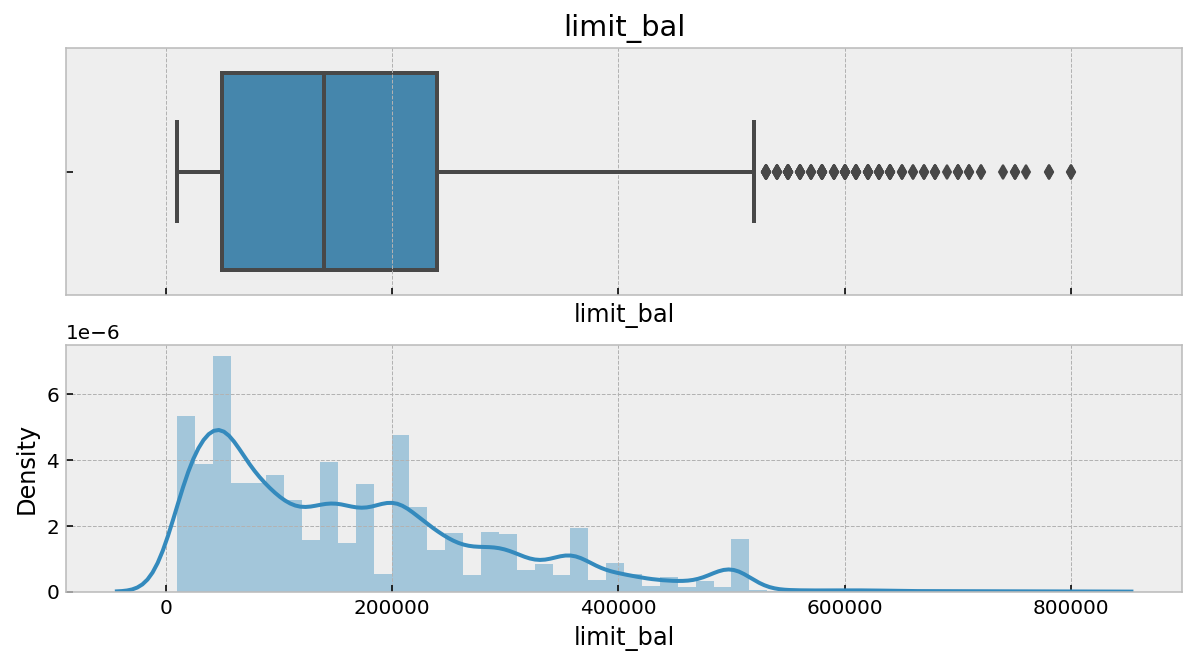

Min: 10,000
Q1 (25%): 50,000
Median: 140,000
Mean: 166,551
Q3 (75%): 240,000
Max:  800,000


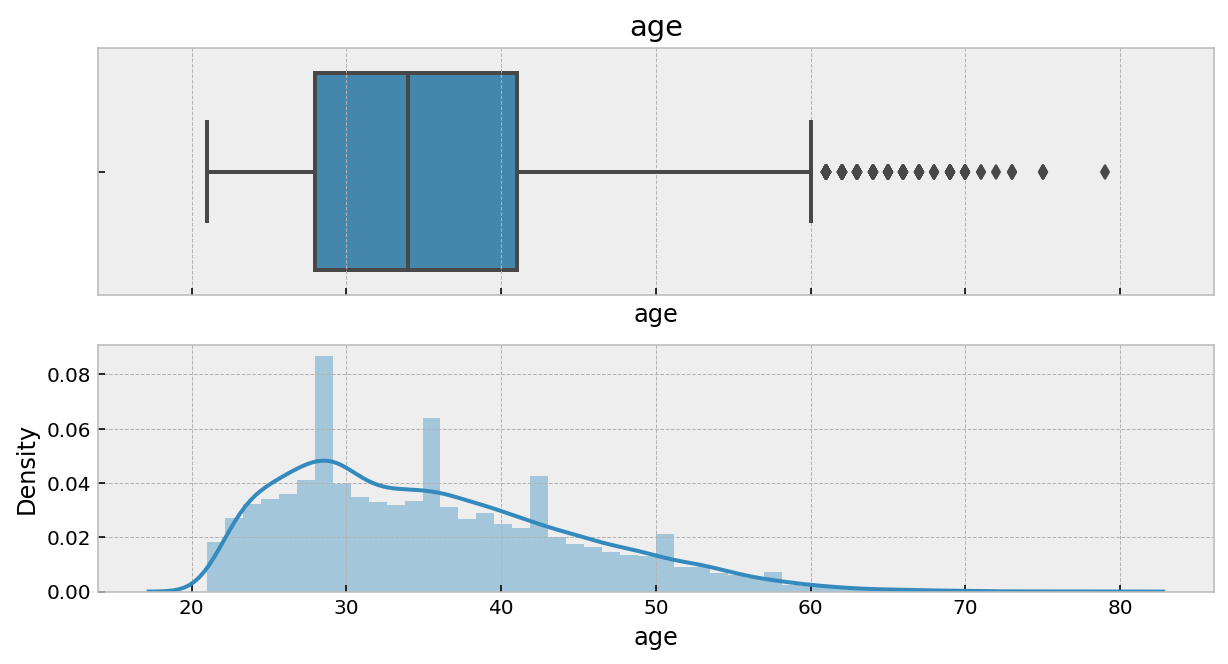

Min: 21
Q1 (25%): 28
Median: 34
Mean: 36
Q3 (75%): 41
Max:  79


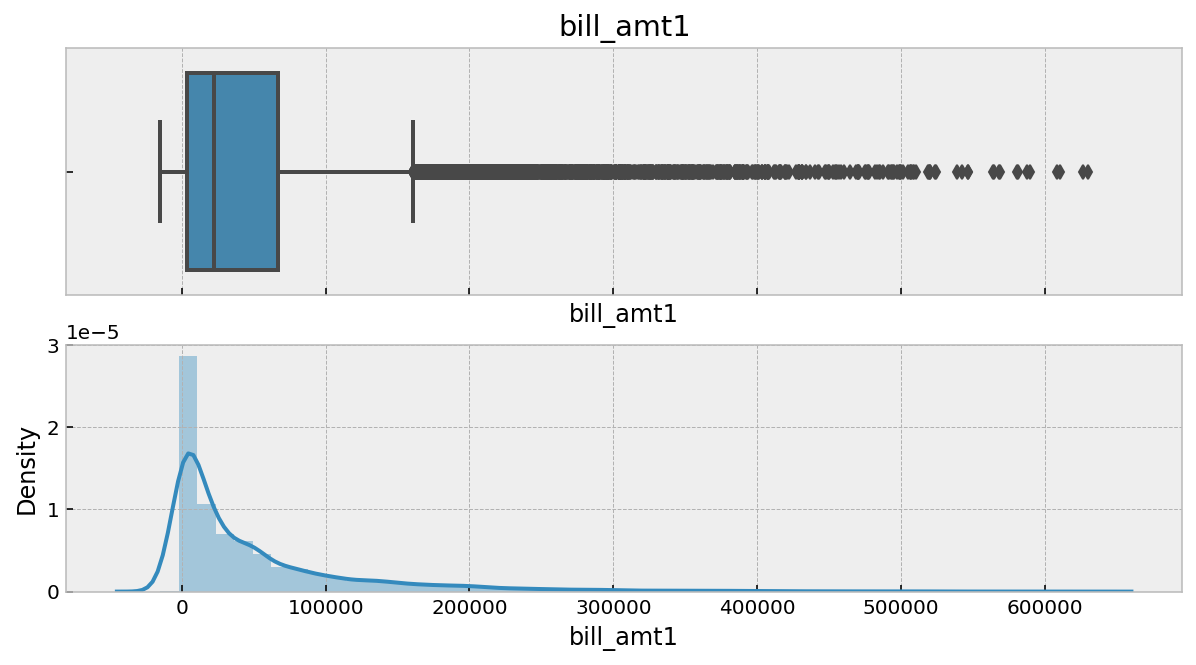

Min: -15,308
Q1 (25%): 3,556
Median: 22,225
Mean: 50,928
Q3 (75%): 66,472
Max:  630,458


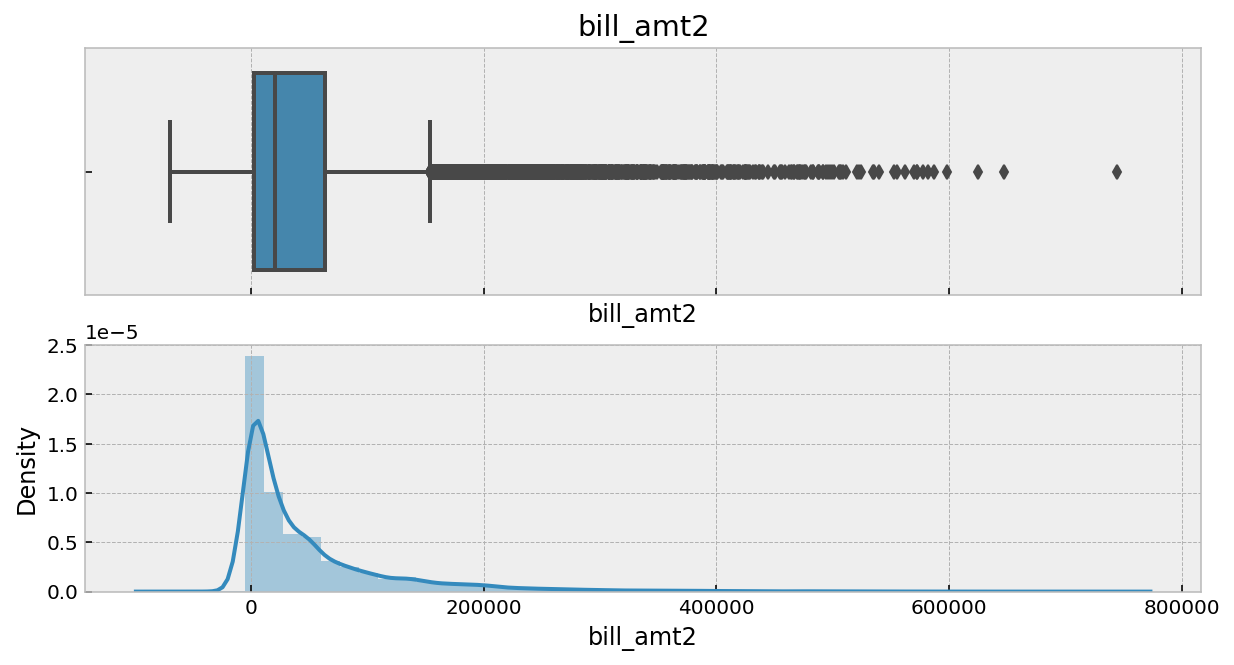

Min: -69,777
Q1 (25%): 2,996
Median: 20,927
Mean: 48,898
Q3 (75%): 63,362
Max:  743,970


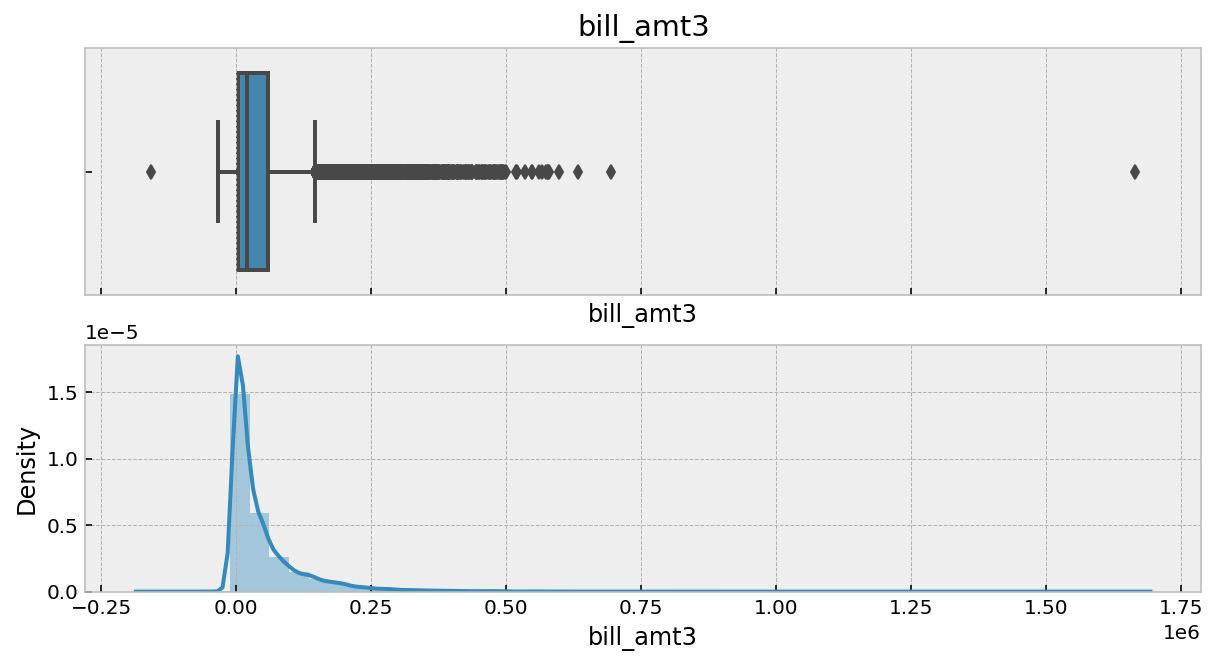

Min: -157,264
Q1 (25%): 2,663
Median: 19,894
Mean: 46,732
Q3 (75%): 59,628
Max:  1,664,089


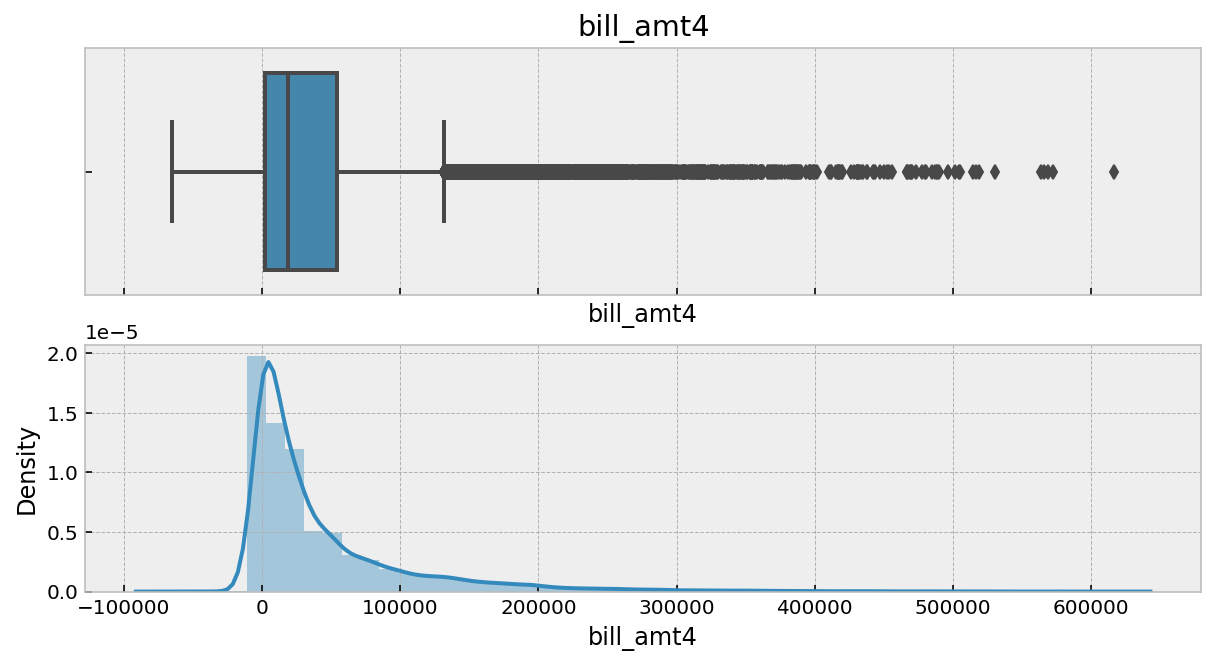

Min: -65,167
Q1 (25%): 2,341
Median: 19,037
Mean: 43,136
Q3 (75%): 54,005
Max:  616,836


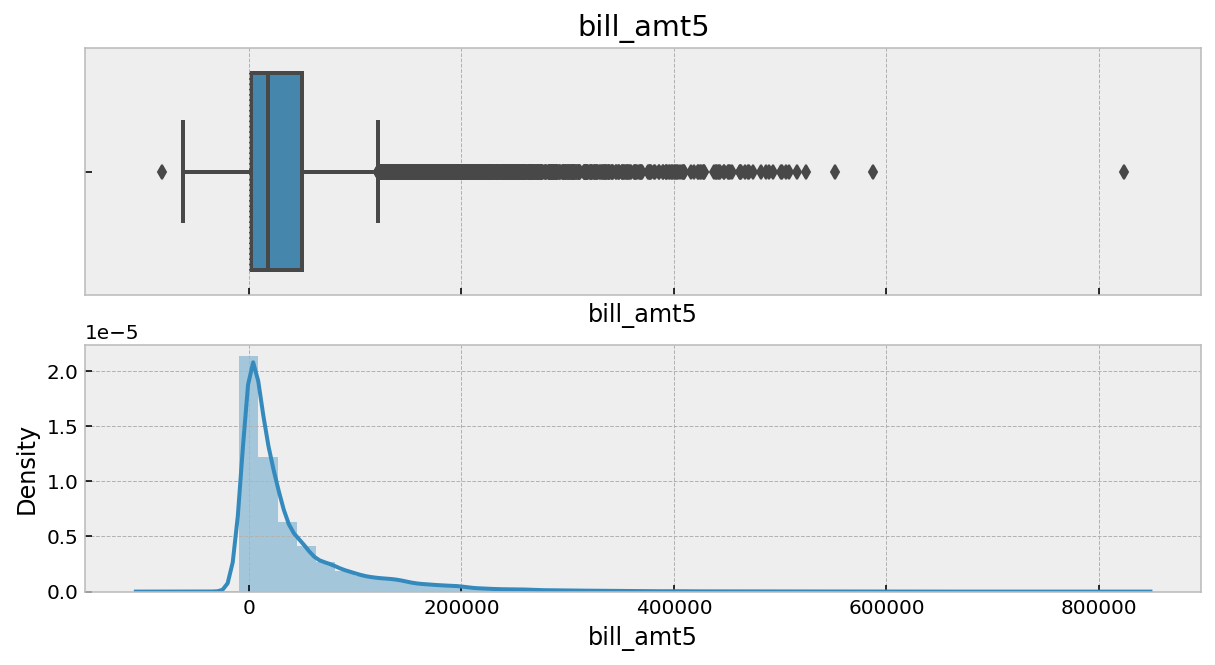

Min: -81,334
Q1 (25%): 1,838
Median: 18,050
Mean: 40,046
Q3 (75%): 49,902
Max:  823,540


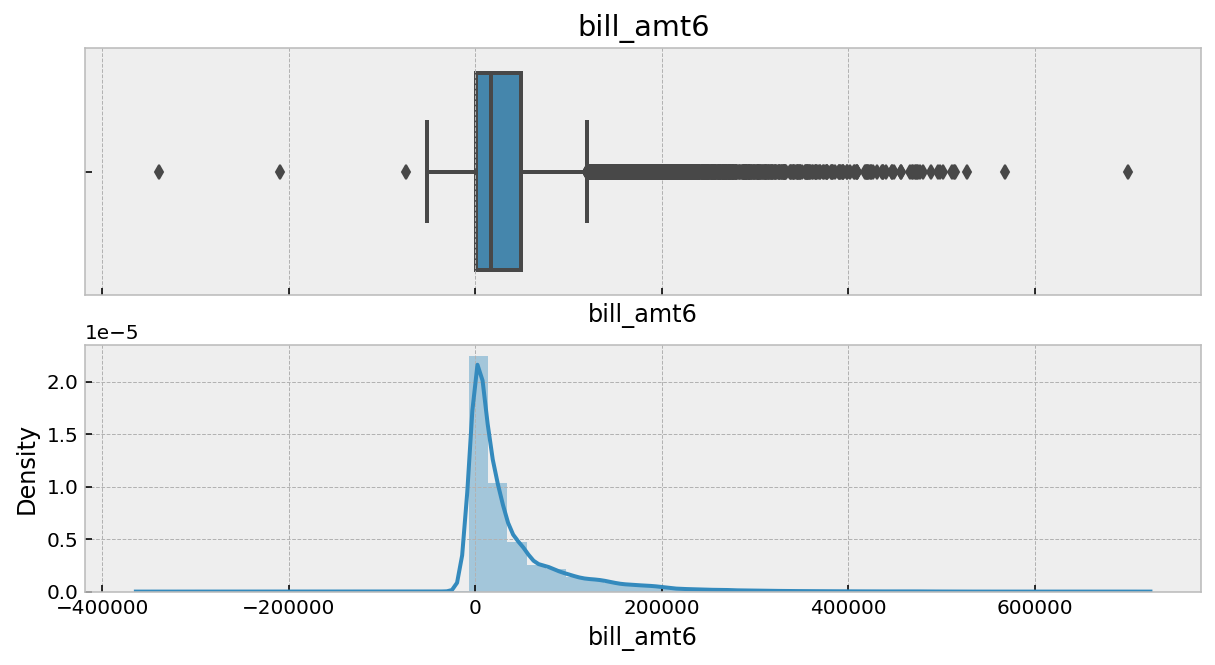

Min: -339,603
Q1 (25%): 1,248
Median: 16,884
Mean: 38,613
Q3 (75%): 48,880
Max:  699,944


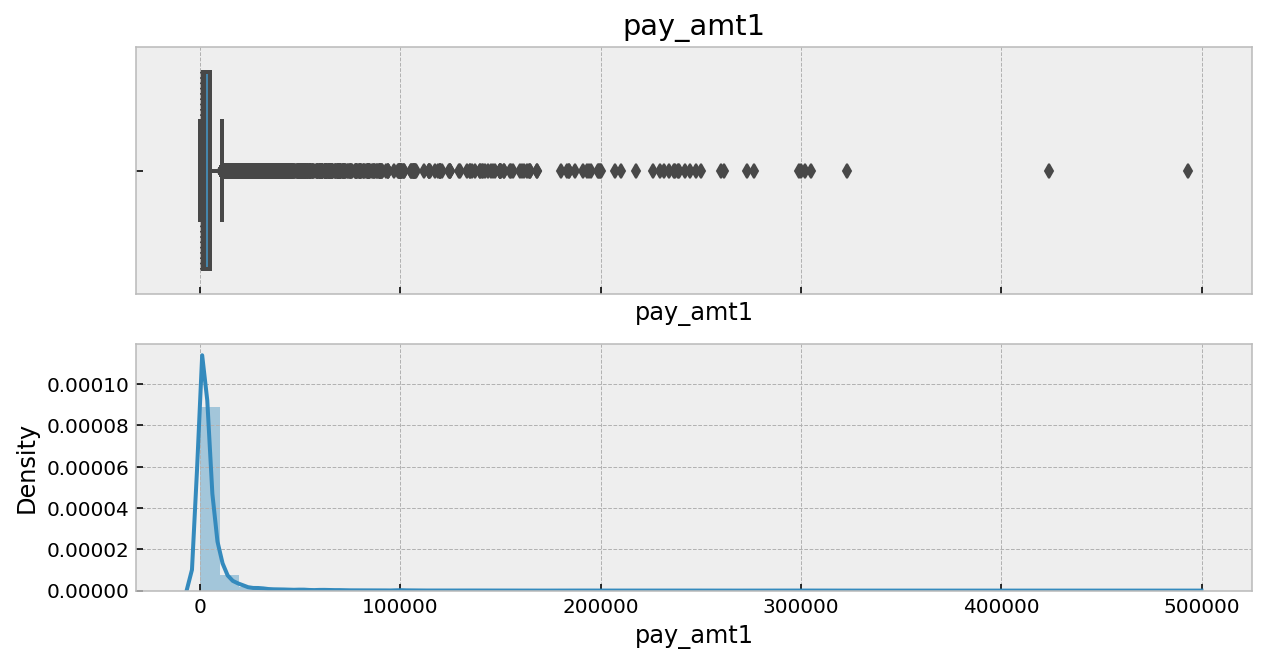

Min: 0
Q1 (25%): 1,000
Median: 2,100
Mean: 5,685
Q3 (75%): 5,009
Max:  493,358


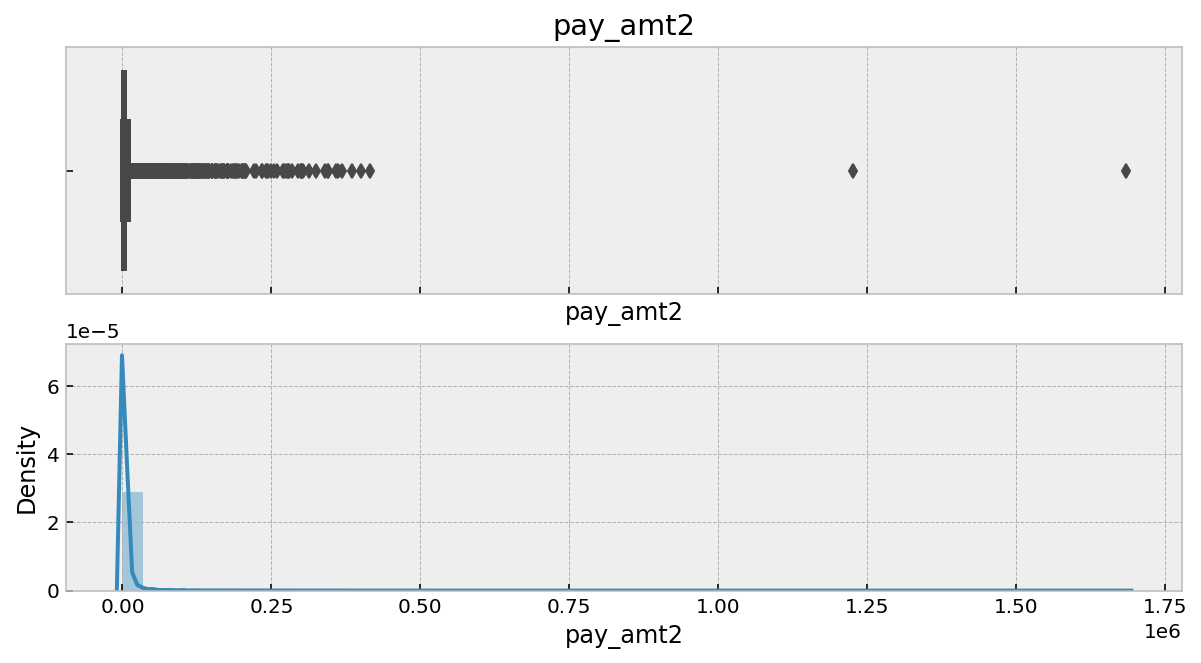

Min: 0
Q1 (25%): 800
Median: 2,000
Mean: 5,991
Q3 (75%): 5,000
Max:  1,684,259


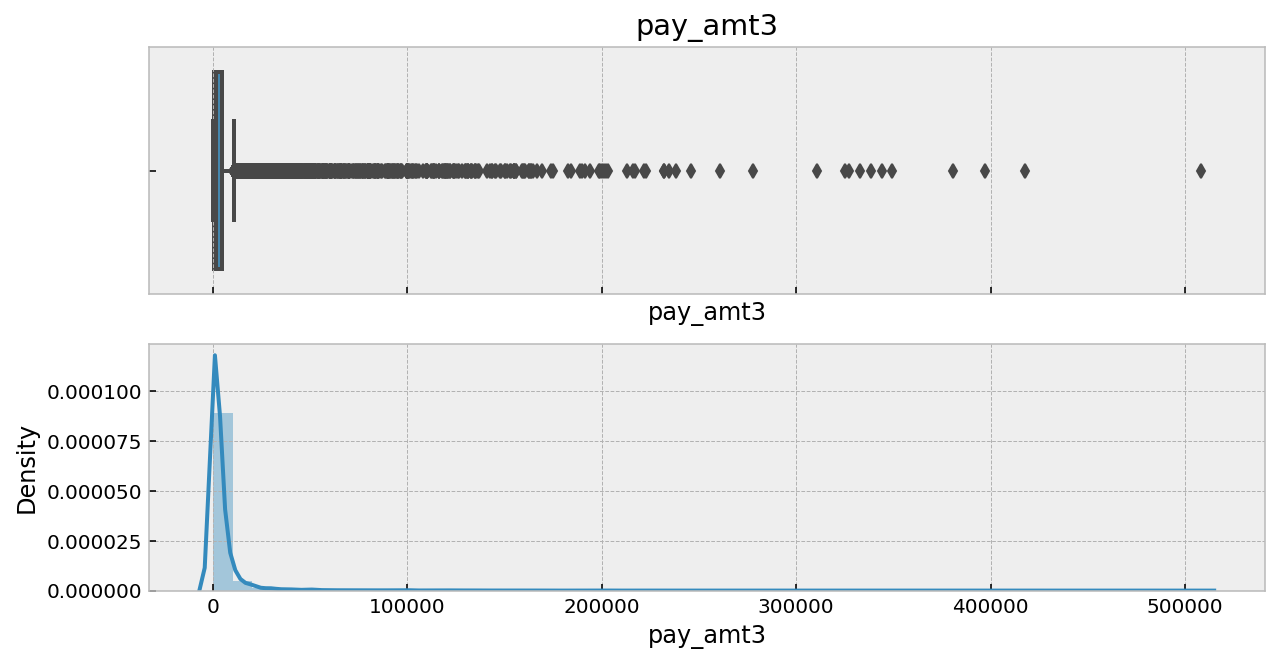

Min: 0
Q1 (25%): 390
Median: 1,781
Mean: 5,291
Q3 (75%): 4,500
Max:  508,229


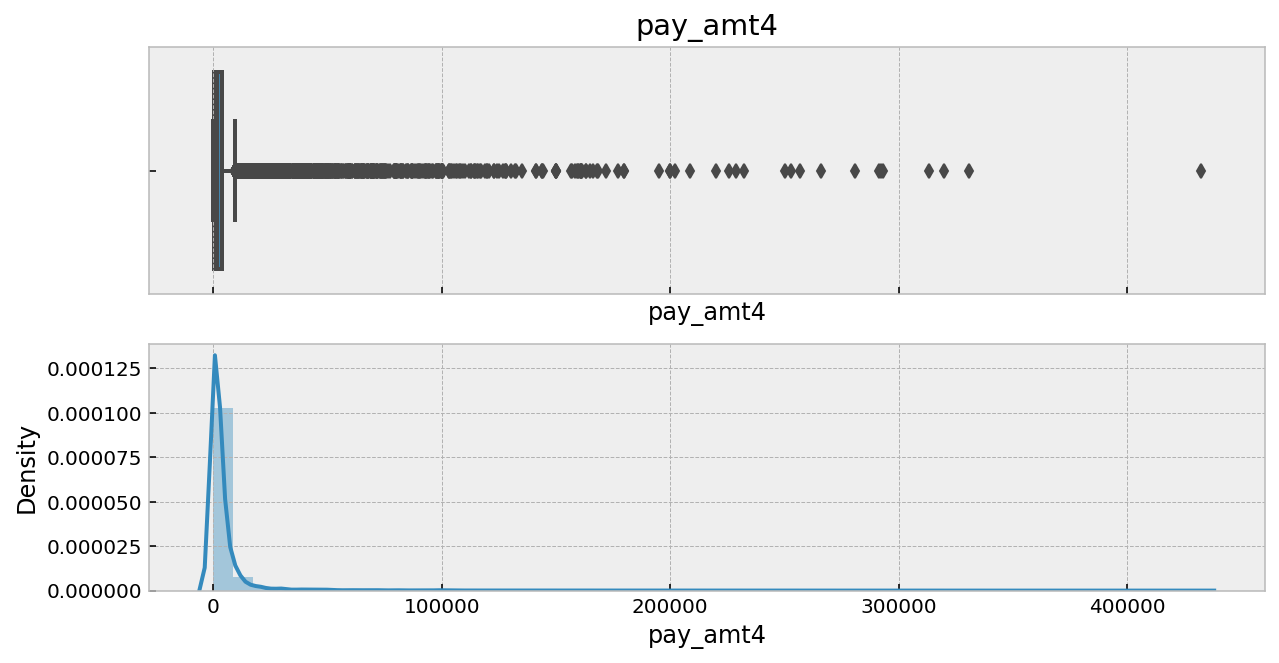

Min: 0
Q1 (25%): 291
Median: 1,500
Mean: 4,731
Q3 (75%): 4,000
Max:  432,130


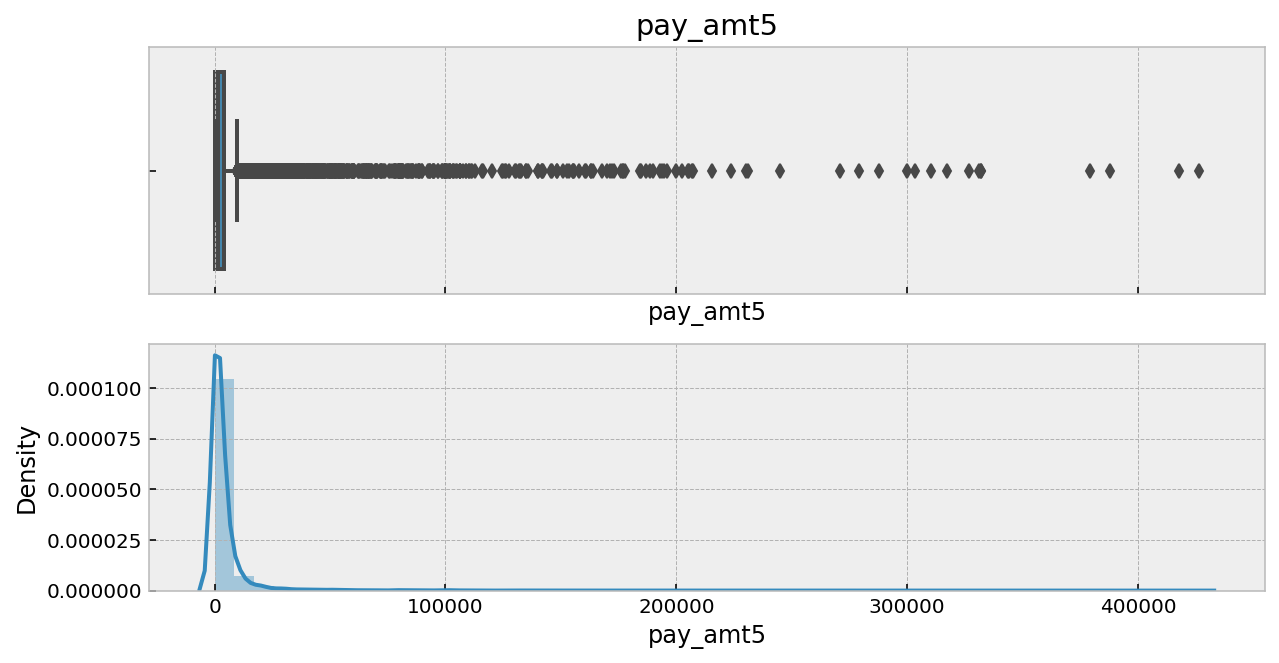

Min: 0
Q1 (25%): 238
Median: 1,500
Mean: 4,792
Q3 (75%): 4,000
Max:  426,529


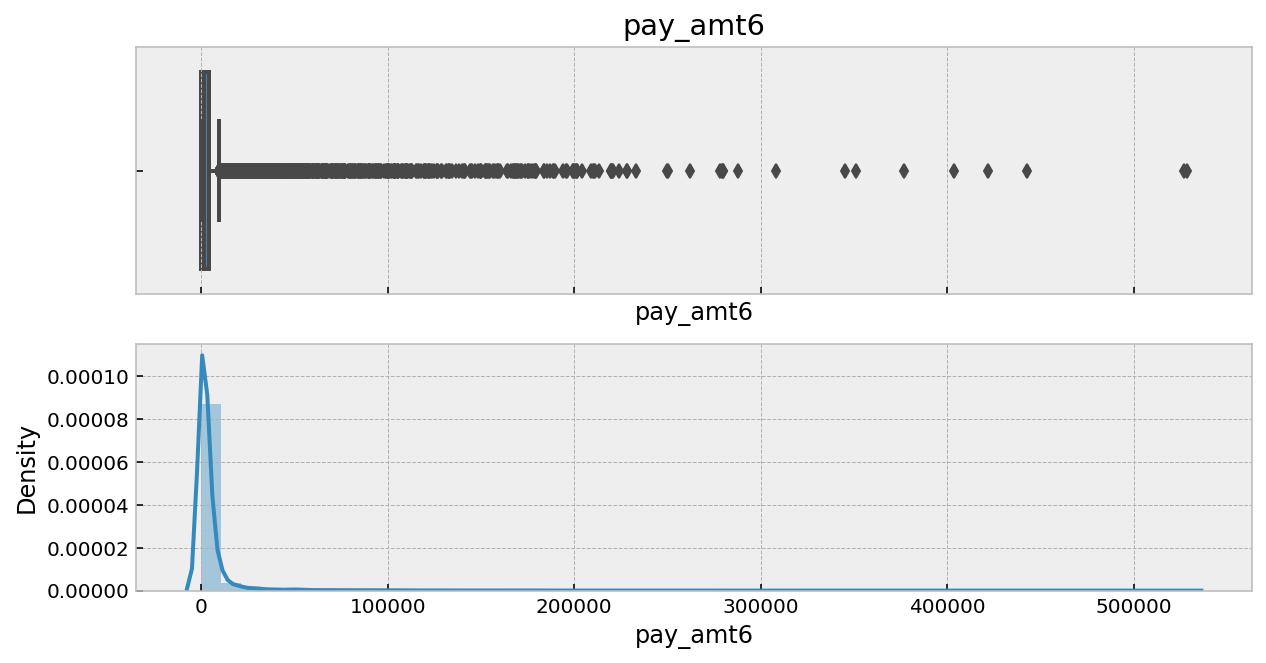

Min: 0
Q1 (25%): 150
Median: 1,500
Mean: 5,326
Q3 (75%): 4,000
Max:  528,666


limit_bal    None
age          None
bill_amt1    None
bill_amt2    None
bill_amt3    None
bill_amt4    None
bill_amt5    None
bill_amt6    None
pay_amt1     None
pay_amt2     None
pay_amt3     None
pay_amt4     None
pay_amt5     None
pay_amt6     None
dtype: object

In [23]:
# Apply summary statistics function to all numerical variables
df_train[numerical_vars].apply(numerical_variable_summary)

#### Observation
- credit limit: median: 140K, right skewed; outliers
- age: median: 34 years, right skewed; outliers
- bill_amt1 to 6 : median: ~20K NT dollars, heavily right skewed; outliers with max of 965K
- pay_amt0 to 6: median: 1500 to 2000 NT dollars, heavily right skewed; outlier with max of around 900K

#### To-do/Questions
- Investigate the outlier, max credit limit, bill amount and pay amount records
- Should we log transform bill and pay amount features? What about credit limit and age?

In [24]:
def discrete_variable_summary(discrete_var):
    
    """ For a given input series outputs no. of records and proportion for each category
    Input: Pandas Series
    Output: Number of records & proportion for each category.
    """
    df_discrete = pd.DataFrame(
        {'No_of_records' : discrete_var.value_counts(),
         '%records' : discrete_var.value_counts(normalize=True)})
    df_discrete.index.names = ['Code']
    print("\nVariable: ",discrete_var.name)
    print("*********************\n")
    print(df_discrete)

In [25]:
# Get discrete variables
discrete_vars = [column for column in df_train if df_train[column].dtype == "object"]
discrete_vars

['sex',
 'education',
 'marriage',
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'is_default']

In [26]:
df_train[discrete_vars].apply(discrete_variable_summary)


Variable:  sex
*********************

      No_of_records  %records
Code                         
2             12645  0.602861
1              8330  0.397139

Variable:  education
*********************

      No_of_records  %records
Code                         
2              9773  0.465936
1              7386  0.352133
3              3485  0.166150
5               202  0.009631
4                81  0.003862
6                38  0.001812
0                10  0.000477

Variable:  marriage
*********************

      No_of_records  %records
Code                         
2             11148  0.531490
1              9561  0.455828
3               228  0.010870
0                38  0.001812

Variable:  pay_0
*********************

      No_of_records  %records
Code                         
0             10312  0.491633
-1             4014  0.191371
1              2552  0.121669
-2             1923  0.091681
2              1840  0.087723
3               225  0.010727
4                57  

sex           None
education     None
marriage      None
pay_0         None
pay_2         None
pay_3         None
pay_4         None
pay_5         None
pay_6         None
is_default    None
dtype: object

#### Observation/Decision
- Education: Has undefined code namely '0', '5', '6'
    - Need to investigate
    - '5' & '6' are typically less and could possibly be combined into defined code for other category, which is '4'
- Marriage: Has undefined code, 0
    - Combine '0' into defined code for other, which is '3'
- Pay_x (pay_0, pay_2 to pay_6)
    - Needs to be investigated for undefined codes '-2' and '0'

> Analyzing undefined categories (-2 and 0) in pay_0, pay_1 to pay_6

#### First let's look at records with '-2' in all the pay_x columns
- Note: pay_0, pay_2 to pay_6 columns hereafter will be collectively written as pay_x

In [27]:
# '-2' in all pay_x columns
data = df_train[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']]
# All pay_x columns with '-2'
all_minus2_in_pay_x  = data[data.apply(lambda x: x == '-2').all(axis=1)]
# Default class proportion among those records
df_train.loc[list(all_minus2_in_pay_x.index)]['is_default'].value_counts(normalize = True)

0    0.867128
1    0.132872
Name: is_default, dtype: float64

> 87% are non-defaulters among the customers with '-2' as their payment status for all pay_x columns

In [28]:
# -2 in all pay_x columns with is_default = 0 (non-defaulters)
df_train.loc[list(all_minus2_in_pay_x.index)][df_train.is_default == '0'].T

ID,12647,27154,19904,20052,15505,21589,10428,23141,12870,26069,...,13266,28436,29351,5246,15330,6765,26887,16450,7587,26009
limit_bal,500000,360000,380000,300000,360000,500000,100000,310000,500000,240000,...,300000,260000,180000,240000,390000,80000,330000,120000,260000,100000
sex,1,1,2,2,1,2,2,2,1,2,...,1,2,1,2,2,2,1,2,2,2
education,3,2,1,1,3,1,2,2,2,1,...,1,2,1,2,1,1,3,1,1,2
marriage,2,1,1,1,1,2,1,1,1,1,...,2,1,2,1,2,1,1,1,2,1
age,31,37,40,39,27,37,49,39,35,32,...,29,34,28,34,33,29,39,60,34,39
pay_0,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
pay_2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
pay_3,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
pay_4,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
pay_5,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2


In [29]:
# -2 in all pay_x columns with is_default = 1 (defaulters)
df_train.loc[list(all_minus2_in_pay_x.index)][df_train.is_default == '1'].T

ID,12540,15149,28466,28322,8545,9175,19184,1005,29115,9693,...,26405,25146,6252,2484,13637,13316,19292,19224,29909,6184
limit_bal,250000,250000,240000,200000,450000,410000,160000,150000,300000,360000,...,120000,300000,120000,80000,230000,240000,120000,330000,140000,430000
sex,2,1,2,2,1,2,2,2,2,1,...,2,1,2,2,1,2,2,2,1,2
education,3,1,1,3,1,1,2,3,3,1,...,2,3,2,2,1,2,2,1,1,2
marriage,1,1,1,1,1,1,1,2,1,2,...,1,1,1,1,2,1,2,2,2,2
age,49,53,40,28,34,46,40,30,50,35,...,46,56,43,23,42,40,39,38,29,27
pay_0,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
pay_2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
pay_3,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
pay_4,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
pay_5,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2


> '-2' in the payment status (pay_x columns) are identifying customers who are either inactive or on a recurring payment (auto-pay) mode

In [30]:
# zero in all pay_x columns
data = df_train[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']]
all_zero_in_pay_x  = data[data.apply(lambda x: x == '0').all(axis=1)]
df_train.loc[list(all_zero_in_pay_x.index)]['is_default'].value_counts(normalize = True)

0    0.891522
1    0.108478
Name: is_default, dtype: float64

> Similar to '-2', majority of the customers with '0' in pay_x columns are non-defaulters (90-10 split). 

In [31]:
# zero in all pay_x columns with is_default = 1
df_train.loc[list(all_zero_in_pay_x.index)][df_train.is_default == '1'].T

ID,20829,1980,12556,8260,3061,2262,26449,1231,20134,28930,...,20101,23964,12526,22745,8308,23011,17818,4812,16756,12153
limit_bal,20000,500000,150000,60000,150000,100000,50000,50000,110000,200000,...,30000,20000,327680,340000,130000,230000,100000,50000,70000,20000
sex,1,2,2,2,2,1,2,2,2,2,...,2,1,1,2,1,2,1,1,1,2
education,3,1,1,2,3,3,2,2,3,1,...,3,2,3,2,2,2,2,2,2,2
marriage,1,1,2,2,1,2,2,2,2,2,...,1,2,2,1,2,1,2,2,1,2
age,48,35,30,23,45,30,52,22,46,44,...,37,27,42,30,27,43,24,43,35,24
pay_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pay_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pay_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pay_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pay_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# zero in all pay_x columns with is_default = 0
df_train.loc[list(all_zero_in_pay_x.index)][df_train.is_default == '0'].T

ID,10792,6031,22190,29925,21073,2474,22341,27857,7076,19095,...,7306,138,15333,4834,6681,1232,8994,27381,19087,12442
limit_bal,50000,150000,200000,50000,70000,50000,250000,70000,50000,20000,...,50000,210000,200000,110000,130000,680000,50000,430000,180000,460000
sex,2,2,2,1,1,2,2,2,2,2,...,1,2,2,1,1,1,1,1,2,1
education,2,1,3,2,2,3,1,2,3,2,...,2,2,1,3,2,1,3,3,2,1
marriage,2,1,1,1,1,1,2,2,3,1,...,3,1,2,1,1,2,2,1,1,2
age,48,46,29,40,44,47,25,22,43,37,...,51,33,30,52,39,37,44,36,37,34
pay_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pay_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pay_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pay_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pay_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> Customers with '0' seems to be paying minimum amount (pay amount << bill amount)

In [33]:
# -1 in all pay_x columns

data = df_train[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']]
all_minus1_in_pay_x  = data[data.apply(lambda x: x == '-1').all(axis=1)]
df_train.loc[list(all_minus1_in_pay_x.index)]['is_default'].value_counts(normalize = True)

0    0.858993
1    0.141007
Name: is_default, dtype: float64

> As defined, customers with '-1' are so mostly non-defaulters (86 - 14 split). This is similar to proportions with '-2' and '0'.

In [34]:
# -1 in all pay_x columns with is_default = 1
df_train.loc[list(all_minus1_in_pay_x.index)][df_train.is_default == '1'].T

ID,15415,5539,1213,1614,20001,14116,22,5382,14161,12389,...,5102,22687,4846,19751,4597,26778,12563,12972,23165,9219
limit_bal,110000,30000,290000,130000,220000,50000,120000,50000,120000,450000,...,140000,180000,170000,180000,60000,260000,270000,240000,110000,500000
sex,2,2,2,2,2,2,2,1,2,2,...,2,2,1,2,1,1,2,2,2,2
education,3,3,1,1,1,2,2,1,1,2,...,2,1,2,2,1,1,3,1,2,2
marriage,1,2,1,1,1,1,1,2,1,1,...,1,2,2,2,2,2,1,2,1,1
age,63,48,30,35,43,39,39,24,38,37,...,35,33,34,33,30,29,37,29,36,47
pay_0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
pay_2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
pay_3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
pay_4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
pay_5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [35]:
# 2 in all pay_x columns for a record
data = df_train[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']]
all_two_in_pay_x  = data[data.apply(lambda x: x == '2').all(axis=1)]
df_train.loc[list(all_two_in_pay_x.index)]['is_default'].value_counts(normalize = True)

1    0.778409
0    0.221591
Name: is_default, dtype: float64

> As a contrast, customers with '2' in their payment status (in all pay_x columns) i.e, pay their statements with a 2 month delay are mostly labelled as defaulters (78-22 split).

In [36]:
# two in all pay_x columns with is_default = 1
df_train.loc[list(all_two_in_pay_x.index)][df_train.is_default == '1'].T

ID,14650,2462,12067,17130,29139,23100,649,2448,5751,24874,...,16470,1153,9414,14582,26298,28058,11267,27613,7155,3217
limit_bal,200000,30000,70000,80000,70000,60000,280000,50000,160000,70000,...,30000,180000,100000,130000,240000,50000,70000,50000,70000,20000
sex,1,2,2,2,2,2,2,2,2,1,...,2,2,2,2,2,2,2,2,2,2
education,1,2,3,2,2,3,2,2,2,2,...,3,2,1,1,1,3,2,2,3,1
marriage,2,2,1,2,1,2,1,2,2,1,...,1,2,1,2,1,1,1,2,1,2
age,33,26,53,24,51,44,44,41,37,36,...,53,42,39,47,32,34,34,25,27,25
pay_0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
pay_2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
pay_3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
pay_4,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
pay_5,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


#### Observations from analyzing pay_x variables
- When all pay_x = -2 & is_default = 1:
    - In most cases, customers are inactive through that period
    - In some cases, the customes seems to have paid their credit statement in full correctly
        - Not sure why are they labelled as defaulters. Does that mean, we are missing some other critical variable that was used to label the class
        
- When all pay_x = 0 & is_default = 1:
    - In all cases, it seems like customers have paid the minimum amount (i.e pay amount << bill amount) duly across the 6 months
    - Decision: Treat this as separate category

- When all pay_x = 0 & is_default = 0:
    - In all cases, exact scenario like above. pay amount << bill amount but paid duly
    - Not sure, why is this labelled as non-defaulters
        - Looks certain like we are missing other critical variables by which the labels are assigned

- When all pay_x = -1 & is_default = 1:
    - In most cases, customers have recurring auto payment type usage. bill_amt = pay_amt and they have paid it on time 
        - Not sure why are they labelled as defaulters?

- When all pay_x = 2 & is_default = 1:
    - 78% of total population here are defaulters
    - In most cases, customers are paying some minimum amount with delay
    
- Seems like pay_0 (the recent payment history) seems to be more important than older history

#### Decision
- Treat '0' as separate category since these customers are making minimum payments
- Treat '-2' as '-1' since they are mostly inactive customers and not defaulters
- Distribution also suggests we can combine all payment history categories above 2 into one category namely '3'

> Perform data modification (preprocessing) to modify the undefined codes into defined categories across education, marriage and pay_x columns

In [37]:
# Modify dataframe: Education
df_train['education'] = df_train.education.apply(
    lambda x: '4' if x in (['5', '6', '0']) else x)

# Modify dataframe: Marriage
df_train['marriage'] = df_train.marriage.apply(
    lambda x: '3' if x == '0' else x)

# Modify dataframe: Pay_x columns
pay_cols = [col for col in df_train.columns if col.startswith("pay")][:6]
for col in pay_cols:
    df_train[col] = df_train[col].apply(
        lambda x: '3' if x in ('4', '5', '6', '7', '8') else ('-1' if x == '-2' else x))    

### 5.1.1. Outlier Investigation

In [38]:
# Filter outlier data based on Z score; Threhold for outlier: beyond 3 in Zscore
data = df_train[numerical_vars]
data_outlier = data[data.apply(lambda x: np.abs(x - x.mean()) / x.std() > 3).any(axis=1)]

In [39]:
df_train_only_outliers = df_train.loc[list(data_outlier.index)]
df_train_only_outliers.shape

(2100, 24)

> Based on our threhold of values beyond 3 in Z-score scale as outlier, there are around 2K records across all numerous features

In [40]:
select_cols_for_outliers = numerical_vars.copy()
# Choosing only the credit limit, bill and pay amount for investigating the outliers
select_cols_for_outliers.remove('age')
df_train.loc[df_train_only_outliers.index][select_cols_for_outliers].sample(n=16).T

ID,18258,2762,16625,26843,17614,12918,26933,3774,16963,8629,23722,25958,11138,29606,3842,27012
limit_bal,210000,180000,420000,500000,220000,210000,130000,140000,240000,310000,260000,260000,600000,500000,380000,200000
bill_amt1,780,113647,90875,2514,213525,0,139892,0,146696,48815,258885,71864,2585,474934,167061,205277
bill_amt2,390,52992,91789,810,141764,0,131365,0,149707,39593,261183,54050,1649,507062,158903,127
bill_amt3,390,38394,89489,8041,53019,106669,9910,0,151780,104341,262546,0,3474,491956,275057,3627
bill_amt4,390,30332,87076,68595,143408,13333,12909,0,152373,76635,238614,0,1952,430637,156348,6303
bill_amt5,780,110824,55508,72011,136786,12780,0,825,145763,46219,195149,0,2182,376657,153778,73
bill_amt6,390,99661,57771,77931,130596,18472,0,675,148276,55045,195771,0,2305,356636,139177,-63
pay_amt1,0,3000,4118,810,6439,0,6179,0,6930,2063,10000,3090,1652,40024,6000,269
pay_amt2,780,3170,14000,8081,2261,106669,1969,0,6000,76651,11000,0,3480,325,6010,3700
pay_amt3,390,2000,0,68595,143408,13333,131000,0,6000,7129,13067,0,1957,15296,5209,3000


> No action needed since the outliers are legit and valid

## 5.2. Multivariate Analysis

- Correlation between independent variables

In [41]:
num_var_correlation = df_train.corr()

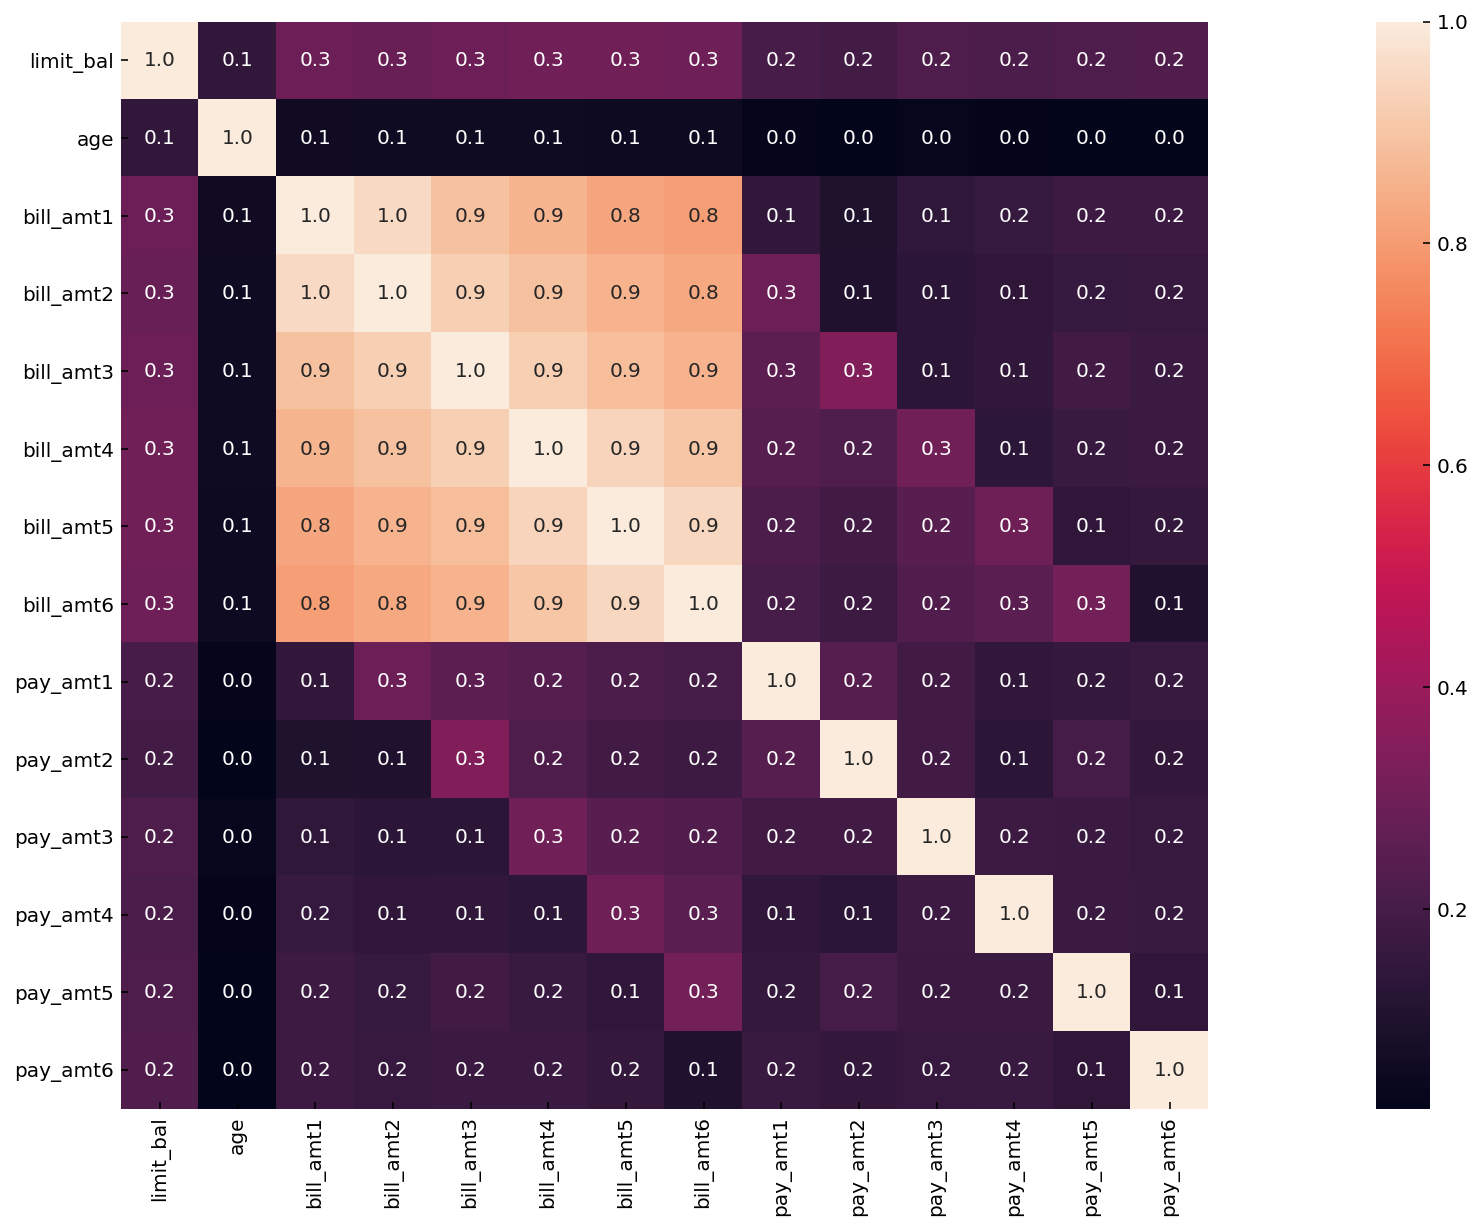

In [42]:
plt.subplots(figsize=(30,10))
sns.heatmap(num_var_correlation, square=True, annot=True, fmt=".1f");

> There is strong correlation between bill_amt variables (bill_amt_1 to bill_amt_6)

- Can we reduce these 6 variables into one variable like average bill amount?

# 6. Feature Engineering

Based on EDA and initial hypothesis, creating two new feature:
- credit_utilization_rate defined as the ratio of avg(bill amount) to credit limit
- revolving_balance_rate defined as the ratio of avg(revolving balance) to credit limit

### 6.1 Create new variable 'credit_utilization_rate' defined as the ratio of avg. bill amount to credit limit

- sum all bill amounts, divide by 6 -> avg. bill amount/month; then divide by credit limit

In [43]:
bill_amt_cols = [cols for cols in df_train if 'bill' in cols]
df_train['credit_utilization_rate'] = (df_train[bill_amt_cols].
                                       sum(axis=1)/6)/df_train.limit_bal
df_train['credit_utilization_rate']

ID
4153     0.448026
14650    0.851338
15415    0.003545
5171    -0.000100
20627    0.128015
           ...   
17799    0.858844
5026     0.949617
11582    0.101302
20264    0.423625
12153    0.186300
Name: credit_utilization_rate, Length: 20975, dtype: float64

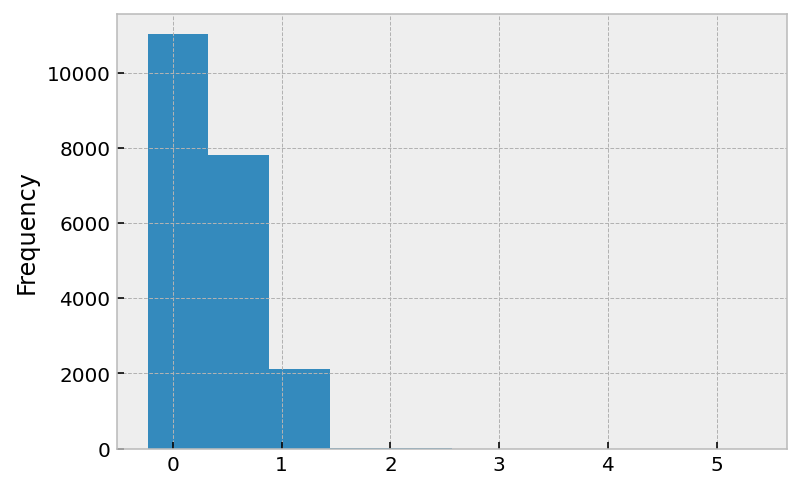

In [44]:
df_train['credit_utilization_rate'].plot(kind = "hist");

### 6.2. Create new variable 'revolving_balance_rate' defined as the ratio of avg.revolving balance and credit limit

- revolving balance is defined as difference between sum of bill_amt2 to bill_amt6 & sum of pay_amt1 to pay_amt5
- sum bill amount 2 to 6 and substract this by sum of paymt1 to 5 -> gives revolving balance. then divide revolving balance by no. of months  -> avg. revolving balance, then divide by credit limit

In [45]:
sum_bill_amt_2_to_6 = df_train[['bill_amt2','bill_amt3','bill_amt4','bill_amt5','bill_amt6']].sum(axis=1) 
sum_pay_amt_1_to_5 = df_train[['pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5']].sum(axis=1)
df_train['revolving_balance_rate'] = ((sum_bill_amt_2_to_6 - sum_pay_amt_1_to_5)/5)/df_train.limit_bal
df_train['revolving_balance_rate']

ID
4153     0.297819
14650    0.823548
15415    0.000000
5171    -0.000086
20627    0.089967
           ...   
17799    0.785180
5026     0.697810
11582    0.014075
20264    0.373080
12153    0.171550
Name: revolving_balance_rate, Length: 20975, dtype: float64

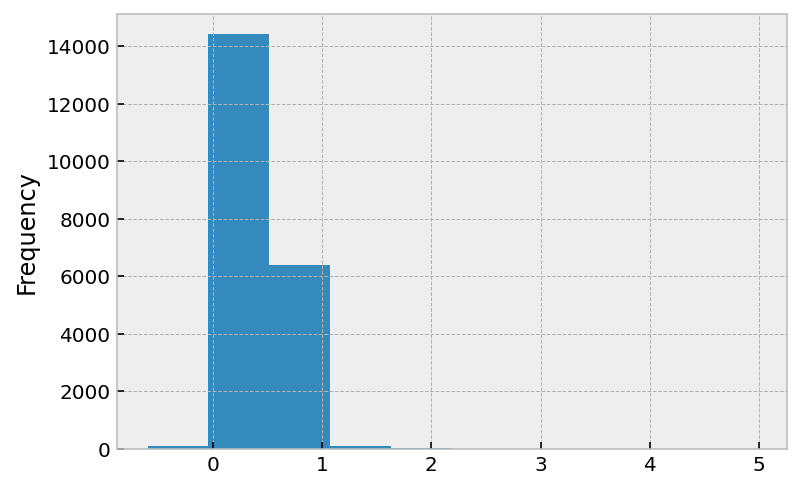

In [46]:
df_train['revolving_balance_rate'].plot(kind = "hist");

### 6.3. Standarize Numerical Variables by Z-Score & One-Hot Encode Categorical Variables

In [47]:
# All discrete variables
categorical_vars = df_train.select_dtypes(include = 'object').columns[:-1]
# All numerical variables
numerical_vars = df_train.select_dtypes(exclude = 'object').columns

In [48]:
# Modify Dataframe: One hot encoding
ohe = OneHotEncoder()
X_train_cat = ohe.fit_transform(df_train[categorical_vars])
ohe.get_feature_names()

array(['x0_1', 'x0_2', 'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x2_1', 'x2_2',
       'x2_3', 'x3_-1', 'x3_0', 'x3_1', 'x3_2', 'x3_3', 'x4_-1', 'x4_0',
       'x4_1', 'x4_2', 'x4_3', 'x5_-1', 'x5_0', 'x5_1', 'x5_2', 'x5_3',
       'x6_-1', 'x6_0', 'x6_1', 'x6_2', 'x6_3', 'x7_-1', 'x7_0', 'x7_2',
       'x7_3', 'x8_-1', 'x8_0', 'x8_2', 'x8_3'], dtype=object)

In [49]:
# Modify Dataframe: Z scaling
scaler = StandardScaler()
X_train_num = scaler.fit_transform(df_train[numerical_vars])

In [50]:
# Combining both numerical and discrete variables after Z scaling and One-hot encoding, respectively
X_train = np.hstack((X_train_num, X_train_cat.todense()))

In [51]:
# Get all feature names after one hot encoding
data_feature_names = list(numerical_vars) + list(ohe.get_feature_names(categorical_vars))

> Should we log transform continuous variables before modeling?

### 6.4. Apply All Preprocessing to Test Data
- Modify education, marriage and pay_x columns
- Create new features 'credit_utilization_rate' and 'revolving_balance_rate' in test dataset
    - Note: Here only the pay_x columns are important for modeling. Education and marriage are converted for consistency and for any future use
- Perform one hot encoding and Z scaling

In [52]:
# Modify Education, Marriage and Pay_x variables in the Test Dataset (as in train dataset) 
X_test['education'] = X_test.education.apply(
    lambda x: '4' if x in (['5', '6', '0']) else x)

X_test['marriage'] = X_test.marriage.apply(
    lambda x: '3' if x == '0' else x)

pay_cols = [col for col in X_test.columns if col.startswith("pay")][:6]

for col in pay_cols:
    X_test[col] = X_test[col].apply(
        lambda x: '3' if x in ('4', '5', '6', '7', '8') else ('-1' if x == '-2' else x))

In [53]:
# Create new features in test: 'credit_utilization_rate'
bill_amt_cols = [cols for cols in X_test if 'bill' in cols]
X_test['credit_utilization_rate'] = (X_test[bill_amt_cols].sum(axis=1)/6)/X_test.limit_bal
X_test['credit_utilization_rate']

#Create 'revolving_balance_rate'
sum_bill_amt_2_to_6 = X_test[['bill_amt2','bill_amt3','bill_amt4','bill_amt5','bill_amt6']].sum(axis=1) 
sum_pay_amt_1_to_5 = X_test[['pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5']].sum(axis=1)
X_test['revolving_balance_rate'] = ((sum_bill_amt_2_to_6 - sum_pay_amt_1_to_5)/5)/X_test.limit_bal
X_test['revolving_balance_rate']

ID
19344    0.579574
908      0.028582
16526    0.000000
26589    0.892330
9903     0.007500
           ...   
167     -0.000145
12762    0.277808
23085   -0.000114
28083    0.454130
6635     0.411320
Name: revolving_balance_rate, Length: 8990, dtype: float64

In [54]:
# Z scaling and One Hot Transformation on the Test Data Set
# One hot transformation
X_test_cat = ohe.transform(X_test[categorical_vars])
# Z scale transformation using values from train data set
X_test_num = scaler.transform(X_test[numerical_vars])
# Combining both numerical and discrete variables after Z scaling and One-hot encoding, respectively
X_test = np.hstack((X_test_num, X_test_cat.todense()))
X_test.shape

(8990, 53)

In [55]:
# Convert Target Variable (both train and test) back to Integer for convenience during modeling
y_train = y_train.astype('int')
y_test = y_test.astype('int')

> Drop age, education, marriage and marital status from the training and test dataset before modeling

In [56]:
# Drop Age, Education, Marriage, Marital Status variables from X_train and X_test
deleted_vars = ['age','sex_1','sex_2','education_1','education_2','education_3','education_4',
 'marriage_1','marriage_2','marriage_3']
feature_names = data_feature_names.copy()
[feature_names.remove(col) for col in deleted_vars]

# Train set
X_train = pd.DataFrame.to_numpy(
    pd.DataFrame(X_train, columns = data_feature_names).
    drop(deleted_vars, axis = 1)
)

# Test set
X_test = pd.DataFrame.to_numpy(
    pd.DataFrame(X_test, columns = data_feature_names).
    drop(deleted_vars, axis = 1)
)

# 8. Modelling
- Use ROC_AUC score to evaluate performance of different classifiers
- Highlevel methodology:
    - Create a baseline (dummy) classifier based on frequent class as the baseline
    - Then evaluate different classifiers such as: logistic regression, randomforest (bagging), gradient boosting (GM), extreme GB (XGB) and light GBM
    - Perform 5 fold cross-validation and grid search and apply the best parameters to fit the test data and evaluate performance
    - Evaluate both train and test ROC_AUC score to identify any overfitting characteristics
    - Upon finalizing a model with the best ROC_AUC score, evaluate precision and recall scores further to evaluate the model
    - Identify key features

In [57]:
def get_roc_auc(X_train, y_train, X_test, y_test, input_model):
    """For a given input model, the function outputs ROC_AUC score for the given train
    and test data. 
    Input: X and y train; X and y test dataset and the model
    Output: Prints train and test ROC_AUC score
    """
    # ROC AUC: For train data
    roc_train = roc_auc_score(y_train, input_model.predict(X_train))
    # ROC AUC: For test data
    roc_test = roc_auc_score(y_test, input_model.predict(X_test))
    print("ROC-AUC \n-------\nTrain: {:,.3f} \nTest: {:,.3f}".format(roc_train,roc_test))
    return None

In [58]:
def do_gridsearchcv_get_roc_auc(X_train, y_train, X_test, y_test,
                                input_model, param_grid,no_k_fold = 5):
    """For a given train, test dataset, input model and grid search parameters, perform grid search. 
    Get the best model and evaluate train and test ROC_AUC score
    Input: X and y train and test dataset, classifier, parameter grid dictionary. 
    Default Input: number of k fold. Default value = 5
    Output: ROC_AUC score for train and test
    """
    grid_search_model = GridSearchCV(
    input_model, param_grid, scoring = "roc_auc", cv = 5, return_train_score=True
    )
    # Fit
    grid_search_model.fit(X_train, y_train)
    #print("CV best score: {:,.3f}\n".format(grid_search_model.best_score_))
    
    # Identify the best parameters and model
    best_model = grid_search_model.best_estimator_
    # Get ROC_AUC score
    get_roc_auc(X_train, y_train, X_test, y_test, best_model)
    return(best_model)

In [59]:
def display_roc_curve(X_test, y_test,
                                input_model, estimator_name):
    """For a test dataset, input model and classifier name, 
    display ROC curve
    Input: X and y test dataset, classifier, classifier name. 
    Output: Displays ROC curve
    """
    # code obtained from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html
    fpr, tpr, thresholds = roc_curve(y_test, input_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name=estimator_name)
    display.plot()
    plt.show()
    return None

In [60]:
def get_prec_recall_confu_matrix(X_test, y_test,
                                input_model, estimator_name):
    """For a test dataset, input model and classifier name, 
    prints precision, recall and confusion matrix
    Input: X and y test dataset, classifier, classifier name. 
    Output: Prints Precision & recall score and confusion matrix
    """
    print("Precision Score: {:,.3f}".format(precision_score(y_test, input_model.predict(X_test))))
    print("Recall Score: {:,.3f}".format(recall_score(y_test, input_model.predict(X_test))))
    print("F1-Score: {:,.3f}".format(f1_score(y_test, input_model.predict(X_test))))
    print("Confusion Matrix: \n{}".format(confusion_matrix(y_test, input_model.predict(X_test))))
    return None

> First let's get a baseline classifier (frequent class based)

In [61]:
# Dummy Classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
get_roc_auc(X_train, y_train, X_test, y_test, dummy_clf)

ROC-AUC 
-------
Train: 0.500 
Test: 0.500


> As expected, the baseline (dummy) classifier gives a 0.5 ROC_AUC

### 8.1. Logistic Regression
- Do a Gridsearch with 5 fold cross validation and based on the best parameters fit and evaluate ROC AUC score

In [62]:
# Logistic Regression Classifier
log_clf = LogisticRegression(class_weight="balanced", random_state = 42)
# Parameter grid search
param_grid = {"C": [0.1,0.5,1],
              "fit_intercept": [True, False],
              "penalty": ["l1","l2"]
}
# Do grid search and get ROC_AUC score
log_clf_model = do_gridsearchcv_get_roc_auc(X_train, y_train, X_test, y_test,log_clf,param_grid)

ROC-AUC 
-------
Train: 0.700 
Test: 0.709


### 8.2. Random Forest Classifier
- Do a Gridsearch with 5 fold cross validation and based on the best parameters fit and evaluate ROC AUC score

In [63]:
# Initialize a random forest classifier
rf_clf = RandomForestClassifier(max_depth = 4, class_weight="balanced", 
                                random_state = 42, max_features= "log2")
# Parameter grid search
param_grid = {"max_depth": [2,4,6],
              "n_estimators": [10,20,100],
              "criterion" : ["gini", "entropy"],
              "max_features":  ["log2","auto"]
}
# Do grid search and get ROC_AUC score
rf_clf_model = do_gridsearchcv_get_roc_auc(X_train, y_train, 
                                               X_test, y_test,
                                               rf_clf,param_grid)

ROC-AUC 
-------
Train: 0.720 
Test: 0.718


### 8.3. XGB Classifier
- Do a Gridsearch with 5 fold cross validation and based on the best parameters fit and evaluate ROC AUC score

In [64]:
# Initialize a XGB classifier
xgb_clf = XGBClassifier()
# Parameter grid search
param_grid = {"max_depth": [1,3,5],
    "n_estimators": [10,30,100],
    "max_leaves":[3,5,7],
    "learning_rate":[0.1,1]
}
# Do grid search and get ROC_AUC score
do_gridsearchcv_get_roc_auc(X_train, y_train, X_test, y_test,xgb_clf,param_grid)

ROC-AUC 
-------
Train: 0.654 
Test: 0.659


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=3, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### 8.4. Light Gradient Boosting Machine

In [65]:
# Initialize a light gradient boosting machine classifier
lgbm_clf = LGBMClassifier(class_weight = "balanced")
# Parameter grid search
param_grid = {"max_depth": [2,3,5],
    "n_estimators": [10,100],
    "learning_rate":[0.1,0.2,0.3]
}
# Do grid search and get ROC_AUC score
lgbm_clf_model = do_gridsearchcv_get_roc_auc(X_train, y_train, 
                                             X_test, y_test,lgbm_clf,param_grid)

ROC-AUC 
-------
Train: 0.713 
Test: 0.715


### 8.5. Model Performance Evaluation

> Model Performance: Logistic Regression

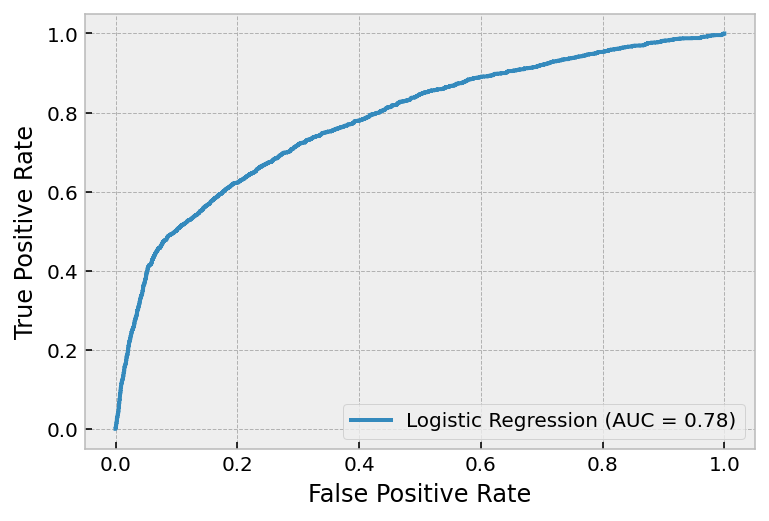

Precision Score: 0.509
Recall Score: 0.576
F1-Score: 0.541
Confusion Matrix: 
[[5896 1105]
 [ 843 1146]]


In [67]:
display_roc_curve(X_test, y_test, log_clf_model, "Logistic Regression")
get_prec_recall_confu_matrix(X_test, y_test, log_clf_model, "Logistic Regression")

> Model Performance: Random Forest

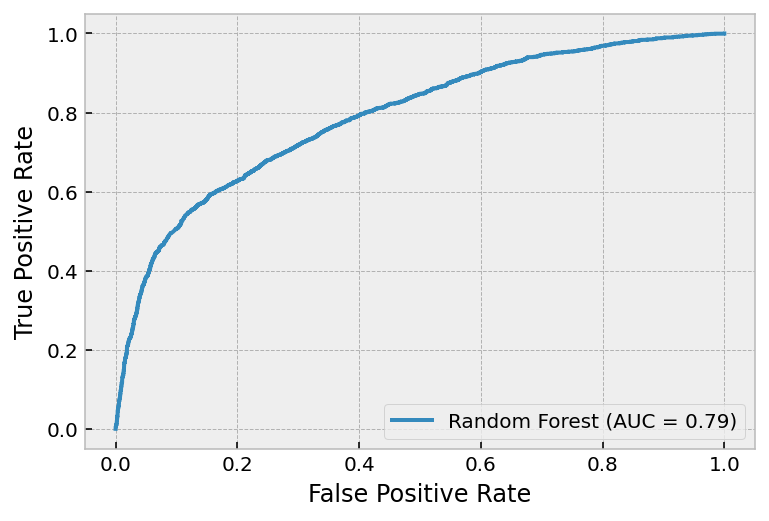

Precision Score: 0.513
Recall Score: 0.596
F1-Score: 0.551
Confusion Matrix: 
[[5873 1128]
 [ 803 1186]]


In [68]:
display_roc_curve(X_test, y_test, rf_clf_model, "Random Forest")
get_prec_recall_confu_matrix(X_test, y_test, rf_clf_model, "Random Forest")

> Random Forest: Feature Importance

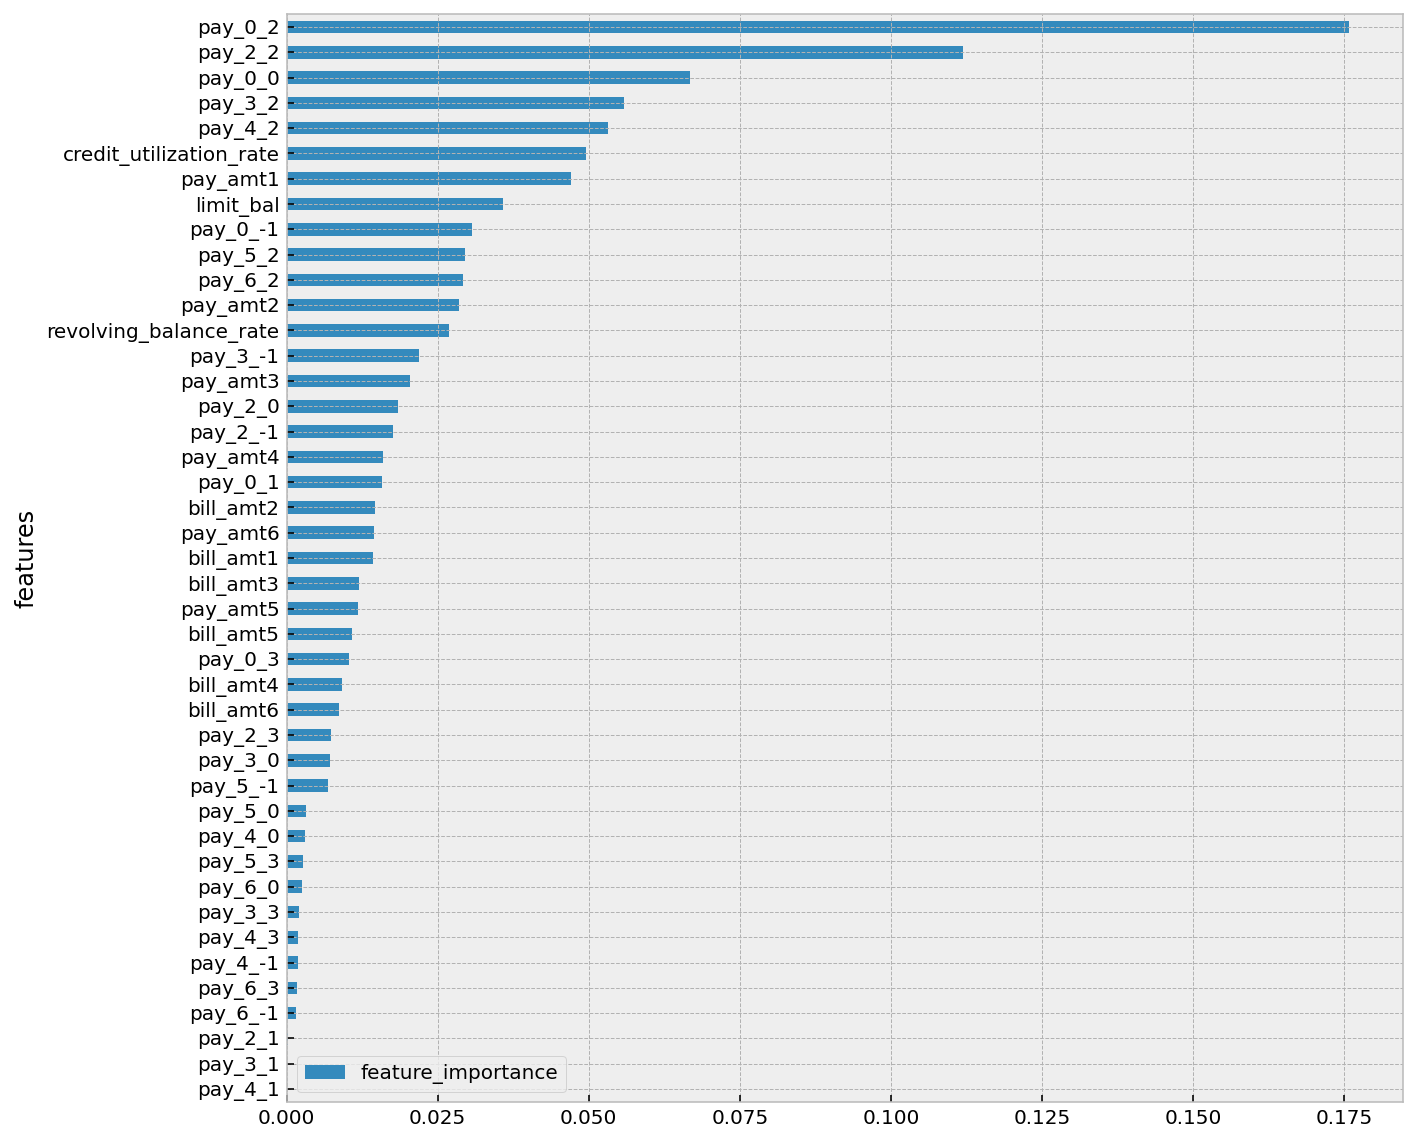

In [69]:
pd.DataFrame({
    "features": feature_names, 
    "feature_importance":rf_clf_model.feature_importances_}).set_index("features")\
.sort_values(by = "feature_importance", ascending = True)\
.plot(kind = "barh", figsize=(10,10));

> Random Forest Feature Importance Summary: Recent month payment status is identified as a key feature to predict default.For example, payment status on September, August, July month is critical to predict default probability for october month. Also credit_utilization_rate is also an revelant feature. 

> Model Performance: Light GBM Classifier

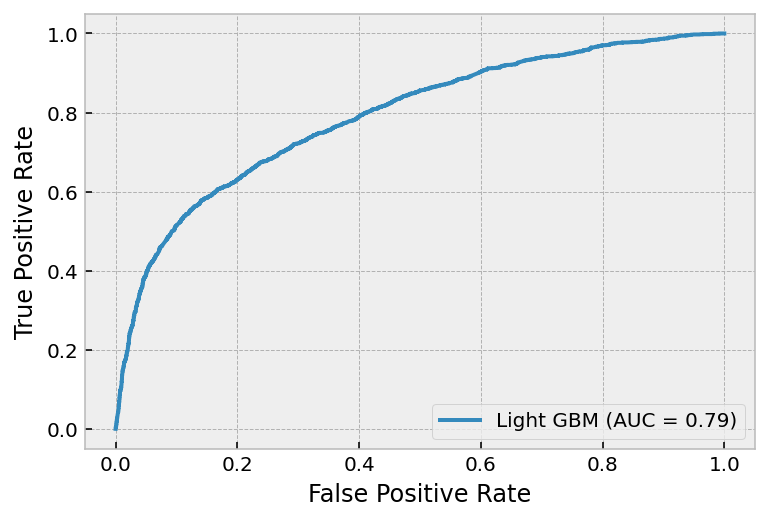

Precision Score: 0.487
Recall Score: 0.615
F1-Score: 0.543
Confusion Matrix: 
[[5712 1289]
 [ 766 1223]]


In [70]:
display_roc_curve(X_test, y_test, lgbm_clf_model, "Light GBM")
get_prec_recall_confu_matrix(X_test, y_test, lgbm_clf_model, "Light GBM")

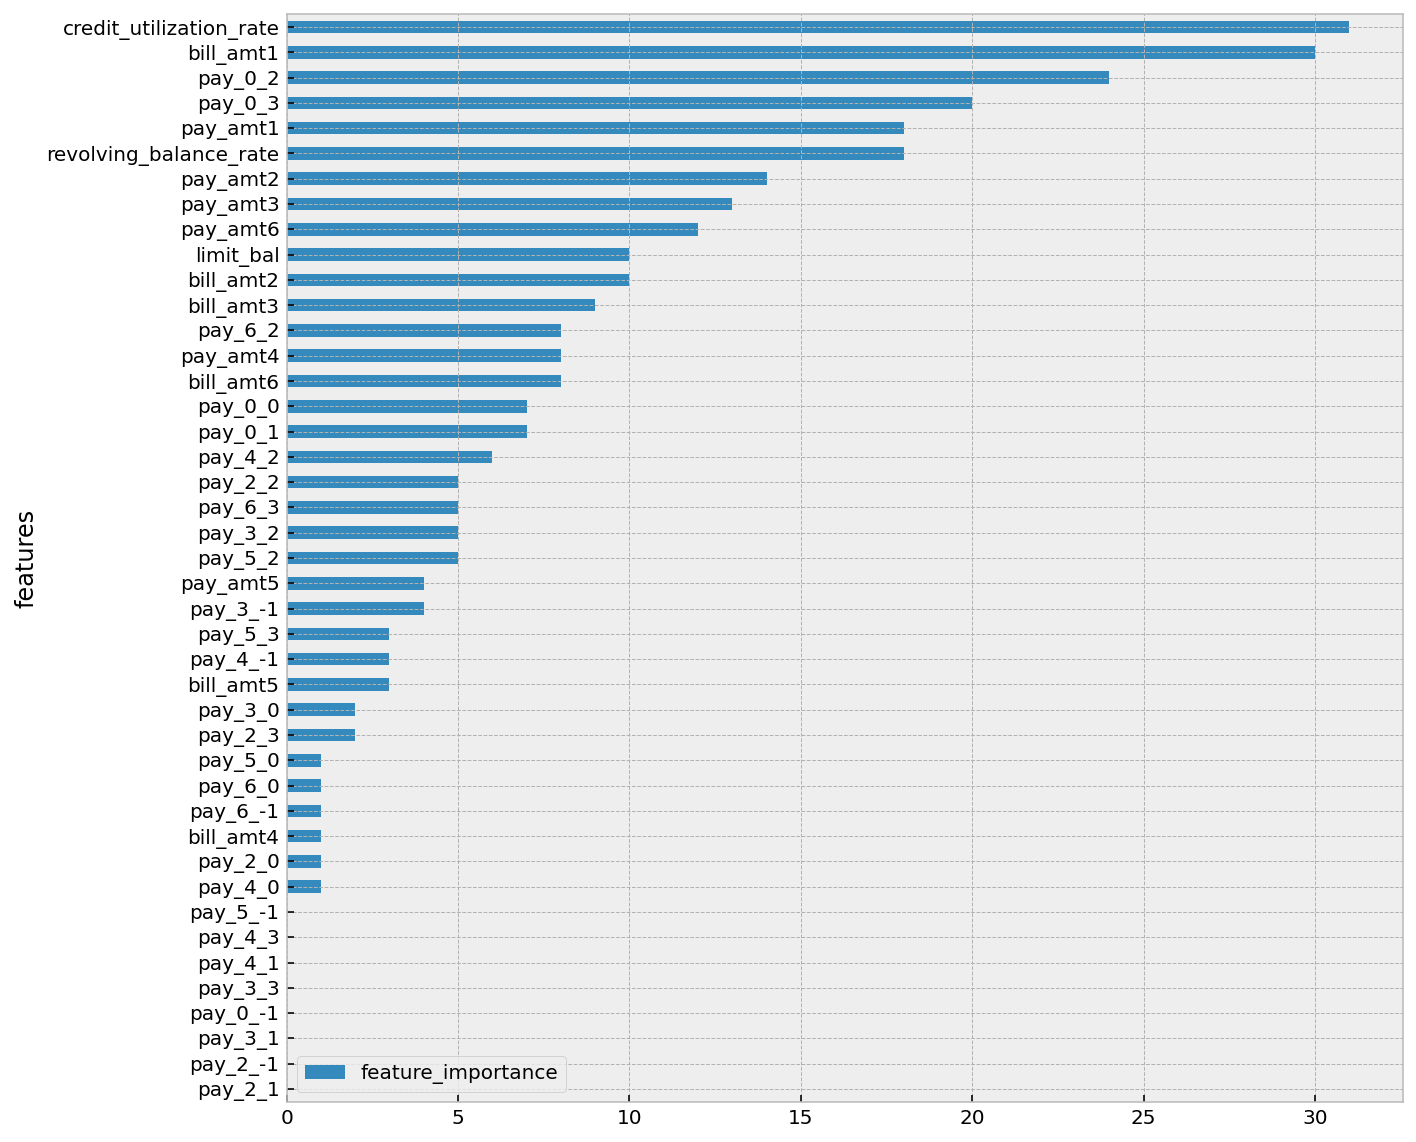

In [71]:
pd.DataFrame({
    "features": feature_names, 
    "feature_importance":lgbm_clf_model.feature_importances_}).set_index("features")\
.sort_values(by = "feature_importance", ascending = True)\
.plot(kind = "barh", figsize=(10,10));

> Light GBM Feature Importance Summary: credit_utilization_rate is identified as the key feature. In addition, recent month payment status & statement, pay amount are also identified as a key feature to predict default.

### 8.6. Model Recommendation: Logistic Regression

- Based on ROC_AUC, Logistic regression, Random Forest and Light GBM all perform similarly. ROC_AUC scores are about 0.7 with Recall of about 0.51 to 0.57.
- Hence depending on other business/technical needs (training data volume, runtime, latency requirements) one choose from Logistic Regression or Random Forest or Light GBM
> I'm choosing Logisitic Regression because of its less complexity than the others and a slightly better Recall than others. ROC_AUC score of 0.7 & Recall score of 0.58.

### 8.7. Final Model:  Logistic Regression

In [72]:
# Logistic Regression Classifier
log_clf = LogisticRegression(class_weight="balanced", random_state = 42)
# Parameter grid search
param_grid = {"C": [0.1,0.5,1],
              "fit_intercept": [True, False],
              "penalty": ["l1","l2"]
}

ROC-AUC 
-------
Train: 0.700 
Test: 0.709


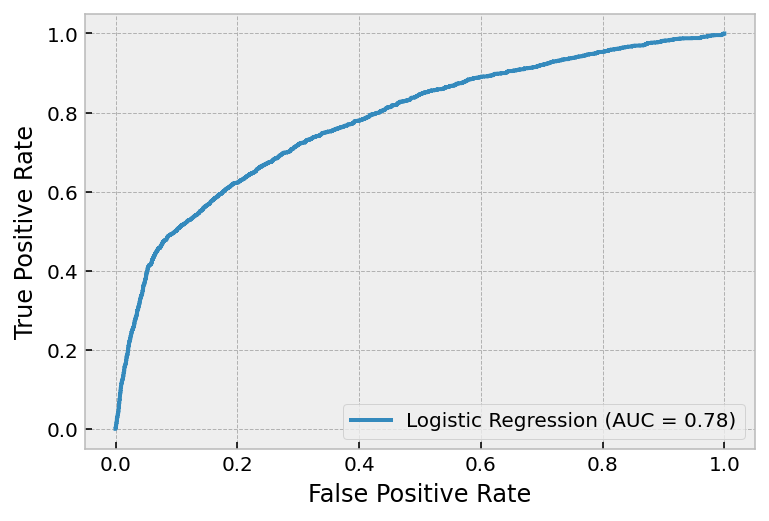

Precision Score: 0.509
Recall Score: 0.576
F1-Score: 0.541
Confusion Matrix: 
[[5896 1105]
 [ 843 1146]]


In [73]:
do_gridsearchcv_get_roc_auc(X_train, y_train, X_test, y_test,log_clf_model,param_grid)
display_roc_curve(X_test, y_test, log_clf_model, "Logistic Regression")
get_prec_recall_confu_matrix(X_test, y_test, log_clf_model, "Logistic Regression")

In [74]:
# Assigning the logistic regression classifier model as the final_model. 
# Use final_model for future analysis
final_model = log_clf_model
final_model

LogisticRegression(C=0.1, class_weight='balanced', fit_intercept=False,
                   random_state=42)

<a id = next_steps></a>
# 9. Next Steps 

- Feature Engineering: Newly created features such as credit_utilization_rate and revolving_balance_rate seems to have high feature importance. Hence with more time, would continue to think of new features from exisiting variables
    - Feature engineering seems have to good effect on the model prediction

- Additional Data: From a product perspective, I would seek additional data such as income, past bankruptcy and other external data such as other loans/debt that can improve our model performance to predict the likelihood of default
    - Clearly as identified in the univariate analysis, some customers albeit their available features being equal to non-defaulters are indeed labelled as defaulters

- Hyper Parameter Tuning: Considering time, did a first pass hyper parameter tuning. With more additional time, it may be worth looking at it further, although it seems the effect is not significant

- To make the production worthy, next step is to build a pipeline for preprocessing the data

[Top](#top)